# Stage 1: Data preprocessing

In this tutorial, we will show how to prepare the necessary data for scCross model training, using the SNARE-seq data ([Chen, et al. 2019](https://doi.org/10.1038/s41587-019-0290-0)) as an example. The SNARE-seq data consists of paired scRNA-seq and scATAC-seq profiles, but we will treat them as unpaired and try to align these two omics layers using scCross.

In [4]:
import anndata
import networkx as nx
import scanpy as sc
import episcanpy as epi
import sccross
from matplotlib import rcParams

In [5]:
sccross.plot.set_publication_params()
rcParams["figure.figsize"] = (4, 4)

NameError: name 'scglue' is not defined

## Read data

First, we need to prepare the scRNA-seq and scATAC-seq data into `AnnData` objects. `AnnData` is the standard data class we use in `sccross`. See their [documentation](https://anndata.readthedocs.io/en/latest/index.html) for more details if you are unfamiliar, including how to construct `AnnData` objects from scratch, and how to read data in other formats (csv, mtx, loom, etc.) into `AnnData` objects.

Here we just load existing `h5ad` files, which is the native file format for `AnnData`. Download links here:
* [Chen-2019-RNA.h5ad](ftp://ftp.cbi.pku.edu.cn/pub/glue-download/Chen-2019-RNA.h5ad)
* [Chen-2019-ATAC.h5ad](ftp://ftp.cbi.pku.edu.cn/pub/glue-download/Chen-2019-ATAC.h5ad)

In [6]:
rna = anndata.read_h5ad("Chen-2019-RNA.h5ad")
rna

AnnData object with n_obs × n_vars = 9190 × 28930
    obs: 'domain', 'cell_type'

In [8]:
atac = anndata.read_h5ad("Chen-2019-ATAC.h5ad")
atac

AnnData object with n_obs × n_vars = 9190 × 241757
    obs: 'domain', 'cell_type'

## Preprocess scRNA-seq data

> (Estimated time: ~2 min)

To begin with, the scRNA-seq expression matrix is supposed to contain raw UMI counts:

In [ ]:
rna.X, rna.X.data

Before any preprocessing, we back up the raw UMI counts in a layer called "counts". It will be used later during model training.

In [9]:
rna.layers["counts"] = rna.X.copy()

Then follow a minimal `scanpy` pipeline for data preprocessing (see their [tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) if you are unfamiliar).

First up we use the "seurat_v3" method to select 2,000 highly variable genes.

In [10]:
sc.pp.highly_variable_genes(rna, n_top_genes=2000, flavor="seurat_v3")

Then normalize, scale the data, and perform dimension reduction via PCA. By default, 100 principal components are used.

The PCA embedding will be used in [stage 2](training.ipynb#Configure-data) as the first encoder transformation to reduce model size.

In [11]:
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)
sc.pp.scale(rna)
sc.tl.pca(rna, n_comps=100, svd_solver="auto")

Optionally, we can visualize the RNA domain with UMAP.

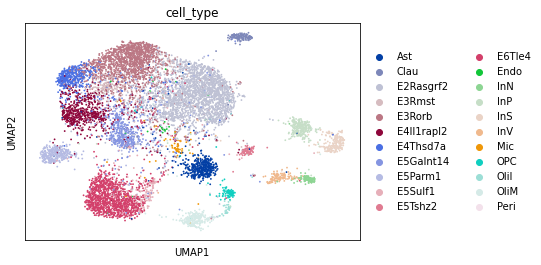

In [12]:
sc.pp.neighbors(rna, metric="cosine")
sc.tl.umap(rna)
sc.pl.umap(rna, color="cell_type")

## Preprocess scATAC-seq data

> (Estimated time: ~2 min)

Similar to scRNA-seq, the scATAC-seq accessibility matrix is also also supposed to contain raw counts.

In [ ]:
atac.X, atac.X.data

For scATAC-seq, we apply the latent semantic indexing (LSI) for dimension reduction, using the function sccross.data.lsi. This is just a Python reimplementation of the LSI function in [Signac](https://satijalab.org/signac/). We also set the dimensionality to 100. The other keyword argument `n_iter=15` is passed to [sklearn.utils.extmath.randomized_svd](https://scikit-learn.org/stable/modules/generated/sklearn.utils.extmath.randomized_svd.html). Setting it to larger values increases the precision of randomized SVD.

The LSI embedding will be used in [stage 2](training.ipynb#Configure-data) as the first encoder transformation to reduce model size.

In [13]:

sccross.data.lsi(atac, n_components=100, n_iter=15)

ModuleNotFoundError: No module named 'pybedtools'

Optionally, we may also visualize the ATAC domain with UMAP.

In [ ]:
sc.pp.neighbors(atac, use_rep="X_lsi", metric="cosine")
sc.tl.umap(atac)

In [ ]:
sc.pl.umap(atac, color="cell_type")

For gaining the gene set, we have to calculate the gene activity matrix for ATAC data. gtf file can be download here: https://www.gencodegenes.org/mouse/

In [ ]:
gene = epi.tl.geneactivity(atac,
	gtf_file='../glue-cross/reference/gencode.vM30.annotation.gtf',
	upstream=2000
	)
atac.uns['gene'] = gene

## Save preprocessed data files

Finally, we save the preprocessed data, for use in [stage 2](training.ipynb).

In [ ]:
rna.write("rna_preprocessed.h5ad", compression="gzip")
atac.write("atac_preprocessed.h5ad", compression="gzip")